<a href="https://colab.research.google.com/github/fookseng/LSTM/blob/main/fs_LSTM_organized.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import datetime
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from google.colab import drive
from google.colab.patches import cv2_imshow # for image display
from tensorflow.keras.models import Sequential, model_from_json, load_model
from tensorflow.keras.layers import InputLayer, Dense, Activation, Flatten, LeakyReLU, ReLU, PReLU, Dropout, BatchNormalization, LSTM
from tensorflow.keras.optimizers import Adam, SGD, Nadam, Adadelta 
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from PIL import Image as im
from keras.preprocessing.image import image
import shutil
import imageio
from numpy import array


In [ ]:
# Check tensorflow version
print(tf.__version__)

2.6.0


In [ ]:
# Mount Google Drive to access data
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Variables initialization

In [ ]:
# The data path of "continuous_for_3".
path = '/content/gdrive/Shareddrives/namr - water quality forecast/1005data_OutletOnly(8x12)/CHL/continuous_for_3'
# The path for saving model
savePath = '/content/gdrive/Shareddrives/namr - water quality forecast/fs/result/'
# Learning Rate
learningRate = 0.001
# Stateful or Stateless. If Stateful, set it to "True", else "False"
stateful = False
state_name = 'stateful' if stateful else 'stateless'
# TSS or CHL model? Set the variable 'tss' to True if this is a TSS model, else false.
tss = False
model_name = "tss" if tss else 'chl'
# The coordinate of pixel
x_pos, y_pos = 5, 7
# 存model路徑
filepath = savePath +'/model_'+ state_name+ '_'+ str(x_pos)+ '_'+ str(y_pos)+ '_' +model_name+'.h5'
# choose a number of time steps
n_steps = 2
# number of features
n_features = 1
# Batch size. For stateful LSTM, batch size must be set properly. Change the batch size only if you sure what you are doing.
n_batch = 6
# Number of epoch. Do not set too high, lower epoch is better for LSTM network.
n_epoch = 100

# Define some variables.
pixel_value_T2 = []
pixel_value_T1 = []
pixel_value_T = []
pattern_data = []
flow_data = []
tide_data = []


# Function Declaration

In [ ]:
def create_data(x, y):
  images_T2 = np.load(path +'/image_array_0.npy')
  images_T1 = np.load(path +'/image_array_1.npy')
  images_T = np.load(path +'/image_array_2.npy')
  flow_T2 = np.load(path +'/flow_array_0.npy')
  flow_T1 = np.load(path +'/flow_array_1.npy')
  flow_T = np.load(path +'/flow_array_2.npy')
  tide_T2 = np.load(path +'/delta_tide_array_0.npy')
  tide_T1 = np.load(path +'/delta_tide_array_1.npy')
  tide_T = np.load(path +'/delta_tide_array_2.npy')

  print("Creating dataset on point:", x,",", y)
  for i in range(tide_T.size):
      pixel_value_T2.append(images_T2[i][x][y])
      pixel_value_T1.append(images_T1[i][x][y])
      pixel_value_T.append(images_T[i][x][y])
      pattern_data.append(images_T2[i][x][y])
      pattern_data.append(images_T1[i][x][y])
      pattern_data.append(images_T[i][x][y])
      flow_data.append(flow_T2[i][0])
      flow_data.append(flow_T1[i][0])
      flow_data.append(flow_T[i][0])
      tide_data.append(tide_T2[i][0])
      tide_data.append(tide_T1[i][0])
      tide_data.append(tide_T[i][0])

  # print(images_T2.size, images_T2.shape)
  # print(images_T1.size, images_T1.shape)
  # print(images_T.size, images_T.shape)
  # print(flow_T2.size, flow_T2.shape)
  # print(flow_T1.size, flow_T1.shape)
  # print(flow_T.size, flow_T.shape)
  # print(tide_T2.size, tide_T2.shape)
  # print(tide_T1.size, tide_T1.shape)
  # print(tide_T.size, tide_T.shape)
  return tide_T.size

In [ ]:
# design network
def build_model_stateful(n_features):
    model = Sequential()
    #model.add(LSTM(64, input_shape=(n_steps, n_features), return_sequences= True, batch_input_shape=(n_batch, x_sampled.shape[1], x_sampled.shape[2]), stateful=True))
    model.add(LSTM(64, input_shape=(n_steps, n_features), return_sequences= True, batch_input_shape=(1, x_sampled.shape[1], x_sampled.shape[2]), stateful=True))
    model.add(LSTM(32, input_shape=(n_steps, n_features), return_sequences=False, batch_input_shape=(1, x_sampled.shape[1], x_sampled.shape[2]), stateful=True))
    model.add(Dense(10, activation=ReLU()))
    model.add(Dense(1, activation=ReLU()))
    model.compile(loss='mean_squared_error', optimizer= Nadam(learning_rate=learningRate), metrics=['mean_squared_error'])
    return model
def build_model_stateless(n_features):
    model = Sequential()
    model.add(LSTM(64, input_shape=(n_steps, n_features), return_sequences= True))
    model.add(LSTM(32, return_sequences=False))
    model.add(Dense(10, activation=ReLU()))
    model.add(Dense(1, activation=ReLU()))
    model.compile(loss='mean_squared_error', optimizer= Nadam(learning_rate=learningRate), metrics=['mean_squared_error'])
    return model

In [ ]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(0, len(sequence), 3):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

# **Main **

Creating dataset on point: 5 , 7
m: 1120

x, y size and shape
2240 (1120, 2, 1)
1120 (1120,)

Visualize the samples.
[0.5470269, 0.54147184, 0.5623691, 0.54147184, 0.5623691, 0.12546857, 0.5623691, 0.12546857, 0.6094713, 0.12546857, 0.6094713, 0.779281, 1.5784324, 1.852881, 1.6529092, 1.852881, 1.6529092, 2.238764, 0.5072158, 0.9666607]
[[0.5470269 ]
 [0.54147184]] 0.5623691
[[0.54147184]
 [0.5623691 ]] 0.12546857
[[0.5623691 ]
 [0.12546857]] 0.6094713
[[0.12546857]
 [0.6094713 ]] 0.779281
[[1.5784324]
 [1.852881 ]] 1.6529092
[[1.852881 ]
 [1.6529092]] 2.238764
[[0.5072158]
 [0.9666607]] 0.54460883
[[0.9666607 ]
 [0.54460883]] 0.6452048
[[0.54460883]
 [0.6452048 ]] 0.55367595
This is a stateless LSTM model
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 2, 64)             16896     
_________________________________________________________________


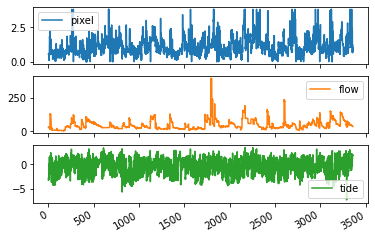

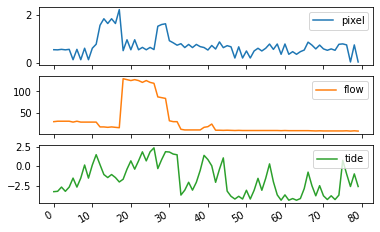

In [ ]:
if __name__ == '__main__':
  ### Create data and save as pandas DataFrame
  m = create_data(x_pos, y_pos)
  print("m: " + str(m))
  dic = {'pixel': pattern_data, 'flow': flow_data, 'tide': tide_data}
  df = pd.DataFrame(dic)
  
  ### Observe statistics and frequency of dataset.
  # df.describe().transpose()
  plot_cols = ['pixel', 'flow', 'tide']
  plot_features = df[plot_cols]
  _ = plot_features.plot(subplots=True)
  plot_features = df[plot_cols][:80]
  _ = plot_features.plot(subplots=True)
  
  ### Split the data (7:2:1 == 784, 224, 112)
  column_indices = {name: i for i, name in enumerate(df.columns)}
  n = len(df)
  train_df = df[0:int(n*0.7)]
  val_df = df[int(n*0.7):int(n*0.9)]
  test_df = df[int(n*0.9):]
  num_features = df.shape[1]

  ### split into samples. These samples will be fed into network for training.
  x_sampled, y_sampled = split_sequence(pattern_data, n_steps)
  ### Reshape the data so that it can fit into the network.
  x_sampled = x_sampled.reshape((x_sampled.shape[0], x_sampled.shape[1], n_features))
  print("\nx, y size and shape")
  print(x_sampled.size, x_sampled.shape)
  print(y_sampled.size, y_sampled.shape)
  print("\nVisualize the samples.")
  print(pattern_data[0:20])
  ### summarize the data, sample pair. ([T-2, T-1]	T)
  for i in range(9):
    print(x_sampled[i], y_sampled[i])
  
  ### Start training the model.
  if (stateful):
    model = build_model_stateful(n_features)
    print("This is a stateful LSTM model")
    model.summary()
    
    # Train network. Stateful LSTM model has to be train in this for loop manner. 
    for i in range(n_epoch):
      # 保留最低loss
      checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True,save_weights_only=False, mode='min')
      # 每過100回合loss都沒降的話就把learning rate乘上factor，最多降到0.00001
      rrp = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=100, verbose=1,min_delta=0.0, mode='min', min_lr=0.00001)
      # 若經過400回合，loss都沒有降低的話就提早停止訓練
      es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=400, min_delta=0.0)
      callbacks_list = [checkpoint,rrp,es]
      model.fit(x_sampled[0:int(m*0.7)], y_sampled[0:int(m*0.7)], epochs=1, batch_size=1, verbose=1, shuffle=False, callbacks=callbacks_list, validation_data=(x_sampled[int(m*0.7):int(m*0.9)],y_sampled[int(m*0.7):int(m*0.9)]))
      model.reset_states()
  else:
    model = build_model_stateless(n_features)
    print("This is a stateless LSTM model")
    model.summary()
    # Train network. 
    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True,save_weights_only=False, mode='min')
    rrp = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=100, verbose=1,min_delta=0.0, mode='min', min_lr=0.00001)
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=400, min_delta=0.0)
    callbacks_list = [checkpoint,rrp,es]
    model.fit(x_sampled[0:int(m*0.7)], y_sampled[0:int(m*0.7)], epochs=n_epoch, batch_size=n_batch, verbose=1, shuffle=True, callbacks=callbacks_list, validation_data=(x_sampled[int(m*0.7):int(m*0.9)],y_sampled[int(m*0.7):int(m*0.9)]))

In [ ]:
# Demonstrate prediction
model = load_model(filepath)
x_test = x_sampled[int(m*0.9):]
y_test = y_sampled[int(m*0.9):]

for i in range(50):
  testX, testy = x_test[i], y_test[i]
  testX = testX.reshape((1, n_steps, n_features))
  yhat = model.predict(testX, batch_size=1)
  print('>Expected=%.1f, Predicted=%.1f' % (testy, yhat))

>Expected=0.7, Predicted=0.8
>Expected=0.7, Predicted=0.8
>Expected=0.7, Predicted=0.7
>Expected=0.7, Predicted=0.7
>Expected=0.8, Predicted=0.8
>Expected=0.9, Predicted=0.9
>Expected=0.8, Predicted=1.2
>Expected=1.0, Predicted=1.4
>Expected=0.9, Predicted=1.0
>Expected=1.0, Predicted=0.9
>Expected=0.9, Predicted=1.0
>Expected=1.0, Predicted=0.9
>Expected=0.4, Predicted=0.4
>Expected=0.5, Predicted=0.5
>Expected=0.6, Predicted=0.6
>Expected=0.8, Predicted=0.7
>Expected=0.7, Predicted=0.6
>Expected=1.2, Predicted=1.5
>Expected=1.2, Predicted=1.2
>Expected=1.0, Predicted=1.2
>Expected=1.2, Predicted=1.1
>Expected=0.6, Predicted=0.6
>Expected=0.4, Predicted=0.5
>Expected=0.4, Predicted=0.3
>Expected=0.6, Predicted=0.6
>Expected=0.7, Predicted=0.7
>Expected=0.4, Predicted=0.6
>Expected=0.7, Predicted=1.1
>Expected=0.7, Predicted=0.7
>Expected=1.6, Predicted=2.0
>Expected=1.3, Predicted=1.6
>Expected=1.8, Predicted=1.3
>Expected=1.9, Predicted=3.7
>Expected=1.7, Predicted=1.5
>Expected=0.7,

In [ ]:
### Compare stateful and stateless model
filepath_stateful = savePath +'/model_'+ "stateful"+ '_'+ str(5)+ '_'+ str(7)+ '_' + "chl"+'.h5'
filepath_stateless = savePath +'/model_'+ "stateless"+ '_'+ str(5)+ '_'+ str(7)+ '_' + "chl"+'.h5'
model_stateful = load_model(filepath_stateful)
model_stateless = load_model(filepath_stateless)
x_test = x_sampled[int(m*0.9):]
y_test = y_sampled[int(m*0.9):]

for i in range(50):
  testX, testy = x_test[i], y_test[i]
  testX = testX.reshape((1, n_steps, n_features))
  yhat = model_stateful.predict(testX, batch_size=1)
  zhat = model_stateless.predict(testX, batch_size=1)
  print('>Stateful Predicted=%.1f, Expected=%.1f, Stateless Predicted=%.1f' % (yhat, testy, zhat))

>Stateful Predicted=0.5, Expected=0.7, Stateless Predicted=0.8
>Stateful Predicted=0.6, Expected=0.7, Stateless Predicted=0.8
>Stateful Predicted=0.7, Expected=0.7, Stateless Predicted=0.7
>Stateful Predicted=0.6, Expected=0.7, Stateless Predicted=0.7
>Stateful Predicted=0.8, Expected=0.8, Stateless Predicted=0.8
>Stateful Predicted=0.9, Expected=0.9, Stateless Predicted=0.9
>Stateful Predicted=1.0, Expected=0.8, Stateless Predicted=1.2
>Stateful Predicted=1.6, Expected=1.0, Stateless Predicted=1.4
>Stateful Predicted=0.9, Expected=0.9, Stateless Predicted=1.0
>Stateful Predicted=1.0, Expected=1.0, Stateless Predicted=0.9
>Stateful Predicted=1.1, Expected=0.9, Stateless Predicted=1.0
>Stateful Predicted=1.1, Expected=1.0, Stateless Predicted=0.9
>Stateful Predicted=0.6, Expected=0.4, Stateless Predicted=0.4
>Stateful Predicted=0.5, Expected=0.5, Stateless Predicted=0.5
>Stateful Predicted=0.5, Expected=0.6, Stateless Predicted=0.6
>Stateful Predicted=0.6, Expected=0.8, Stateless Predic